In [1]:
# Neural Network Basic Forward and Backward propagation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack

In [2]:
df = pd.read_csv('/Users/mac/Documents/GenAI_NLP/NLP/Naveen_NLP/SampleData/amazon_reviews.csv')
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [4]:
print(df.describe(include='all'))

         Unnamed: 0     reviewerName      overall  reviewText  reviewTime  \
count   4915.000000             4914  4915.000000        4914        4915   
unique          NaN             4594          NaN        4912         690   
top             NaN  Amazon Customer          NaN  No issues.  2013-12-30   
freq            NaN              121          NaN           2          26   
mean    2457.000000              NaN     4.587589         NaN         NaN   
std     1418.982617              NaN     0.996845         NaN         NaN   
min        0.000000              NaN     1.000000         NaN         NaN   
25%     1228.500000              NaN     5.000000         NaN         NaN   
50%     2457.000000              NaN     5.000000         NaN         NaN   
75%     3685.500000              NaN     5.000000         NaN         NaN   
max     4914.000000              NaN     5.000000         NaN         NaN   

           day_diff  helpful_yes   helpful_no   total_vote  \
count   4915.

In [5]:
# missing values
print(df.isnull().sum())

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


In [6]:
# check duplicates
print(df.duplicated().sum())

0


In [7]:
# let's take a sample of 1000 rows for faster processing
df_sample = df.sample(n=1000, random_state=42)

### Section 2: Exploratory Data Analysis (EDA)
Goal

Understand data distribution

Detect biases, anomalies, and noise

Derive hypotheses for modeling

Identify potential preprocessing requirements

overall
5.0    3922
4.0     527
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64


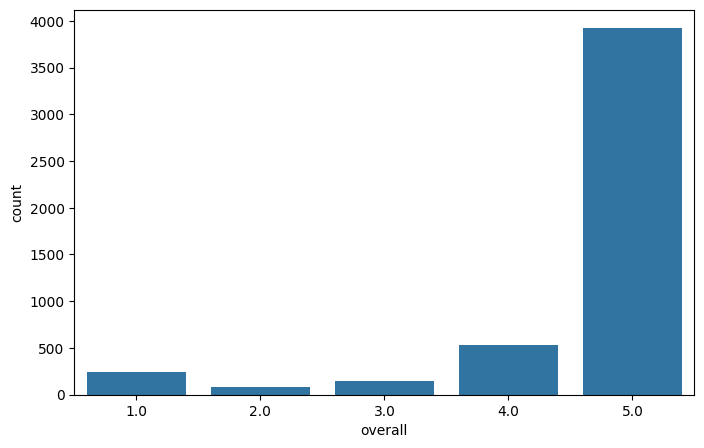

In [8]:
#check overall distribution for target column
plt.figure(figsize=(8,5))
sns.countplot(x='overall', data=df)
print(df['overall'].value_counts())

##### It clearly show that the data is imbalanced in which rating 5 is consumiing almost 70% of outcome. this can be difficult to predict the outcome later. Generally this is very common with sentiment tasks(classification problem where the goal is to predict the emotional polarity (positive, negative, neutral)). this may cause the prediction output for minority class very poor. 

##### How to Handle This:

For Target (label) imbalance:

Use resampling techniques:

Oversample minority (SMOTE, ADASYN).

Undersample majority.

##### “Oversampling increases the representation of minority classes by either duplicating existing samples or generating synthetic ones like in SMOTE or ADASYN. Undersampling reduces the number of majority class samples, either randomly or through informed strategies like Tomek Links. Oversampling risks overfitting, while undersampling risks losing information. The choice depends on dataset size: with a large dataset, undersampling is feasible; with a small dataset, oversampling or class-weighted loss is usually better.”

Use class-weighted loss functions (e.g., in cross-entropy, penalize misclassification of minority class more).

Use evaluation metrics beyond accuracy: F1, Precision-Recall AUC, Balanced Accuracy.

Consider data augmentation (paraphrasing in NLP).

For Feature imbalance:

Normalize/transform distributions (log-scaling for skewed numeric features).

Feature engineering (e.g., TF-IDF in NLP reduces the dominance of common words).

Dimensionality reduction to remove redundancy.

Consider feature selection to drop irrelevant/bias-heavy features.


##### "A sentiment task is an NLP classification problem where we assign emotional polarity to text. If the target distribution is highly biased, the model risks overfitting to the majority class and ignoring the minority. I would address this using class balancing methods like resampling, cost-sensitive loss functions, and by focusing on precision-recall metrics instead of raw accuracy. If feature columns are biased, I’d mitigate by transformations such as TF-IDF for text, normalization for skewed numeric features, or even feature selection. The key is to prevent the model from learning shortcuts from dominant signals and ensure fair representation across classes and features."

Perform the Data Preprocessing always after the train test split, otherwise it can cause you the data leakage problems where unknowingly you can already telling training set about the test values. best practice it to do the data pre-processing only on Training set and lately follow the same paramter during the prediction on test set


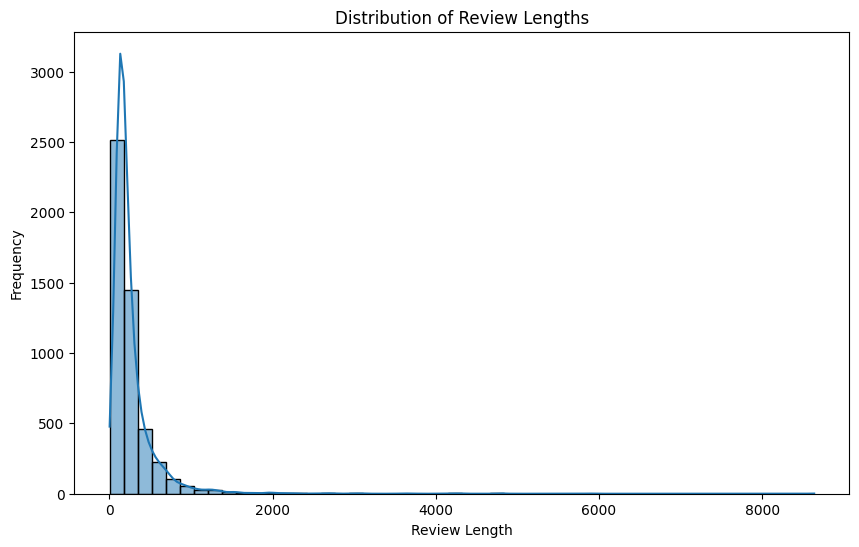

Average length: 267.69359104781284
95th percentile length: 717.3000000000002


In [9]:
# type for reviewText column is Object type which denotes as float or int, it needs to change to string type
df['reviewText'] = df['reviewText'].astype(str)
# check the length of reviews text
df['review_length'] = df['reviewText'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()
print("Average length:", df['review_length'].mean())
print("95th percentile length:", df['review_length'].quantile(0.95))

##### “Reviewing text column lengths means analyzing how long the input sequences are across your dataset. This helps set a maximum sequence length for NLP models like BERT. The trade-off is between efficiency and information retention — a shorter max length reduces computation but risks truncating meaningful parts of long texts, while a longer max length preserves information but increases training cost. Typically, I’d analyze the distribution of tokenized sequence lengths, then pick a cutoff (like the 90th percentile) as the model’s max sequence length.”

🔹 What is Maximum Sequence Length?

When we feed text into deep NLP models (BERT, RoBERTa, LSTMs, GRUs), they don’t take raw text — they take sequences of tokens (numbers).

A sequence length = how many tokens (units) the model processes for each text input.

Since texts are of varying length, we fix a max length so all sequences are uniform.

👉 Example:

Sentence A: “This phone is great.” → 4 tokens

Sentence B: “The laptop was very disappointing, and the battery life was awful.” → 12 tokens

If max_length = 10:

Sentence A (4 tokens) → padded with 6 zeros (to make length = 10).

Sentence B (12 tokens) → truncated to first 10 tokens (losing last 2).

##### 🔹 Context: Binary vs Multi-class Sentiment

Binary classification: Only two labels, e.g., Positive vs Negative.

Multi-class classification: Three or more labels, e.g., Positive, Neutral, Negative.

The choice affects:

Model complexity

Loss function design

Evaluation metrics

##### Why Neutral Class is Tricky

Neutral reviews are ambiguous by nature:

“It’s okay” — is that positive, negative, or really neutral?

Annotator disagreement is high.

Neutral samples often blur the decision boundary for models.

Models tend to confuse neutral with positive/negative, hurting overall accuracy and F1 scores.

##### “Neutral class is inherently ambiguous, often leading to annotator disagreement and model confusion. Researchers sometimes drop 3-star reviews to simplify the problem into a binary classification — Positive vs Negative. This reduces label noise, creates a clearer decision boundary, and improves model performance metrics like F1-score. It’s a conscious trade-off between dataset completeness and label clarity, especially when the main goal is to detect clear positive or negative sentiment.”

##### “Instead of dropping neutral reviews, we can handle them using approaches like thresholding probabilities, ordinal regression, soft labeling, or even a two-step model. These methods acknowledge the ambiguity of neutral sentiment, reduce misclassification noise, and retain the full dataset, allowing the model to learn nuanced patterns rather than ignoring borderline cases. For example, ordinal regression treats sentiment as an ordered scale, while soft labeling assigns partial probabilities to neutral examples, helping the model understand their intermediate nature.”

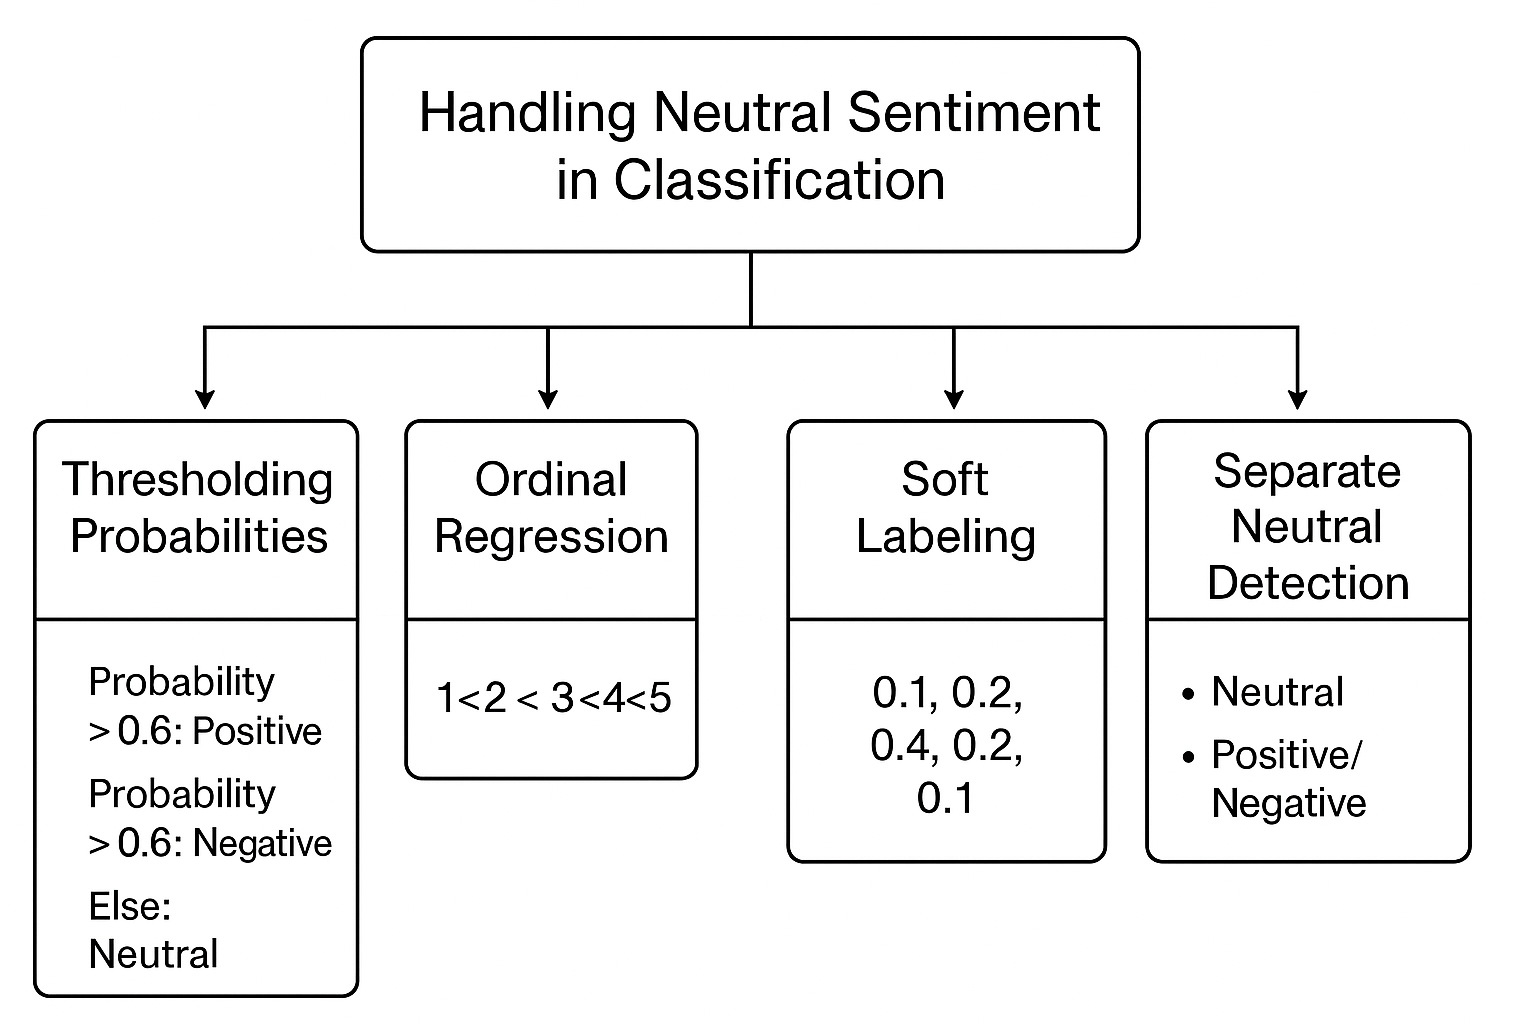


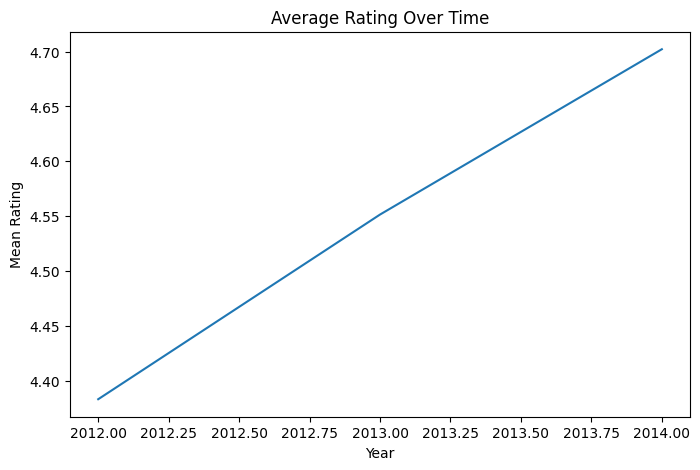

In [10]:
# Check for trends for review date vs overall rating
df['reviewTime'] = pd.to_datetime(df['reviewTime'], errors='coerce')
df['review_year'] = df['reviewTime'].dt.year

df.groupby('review_year')['overall'].mean().plot(kind='line', figsize=(8,5))
plt.title("Average Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Mean Rating")
plt.show()


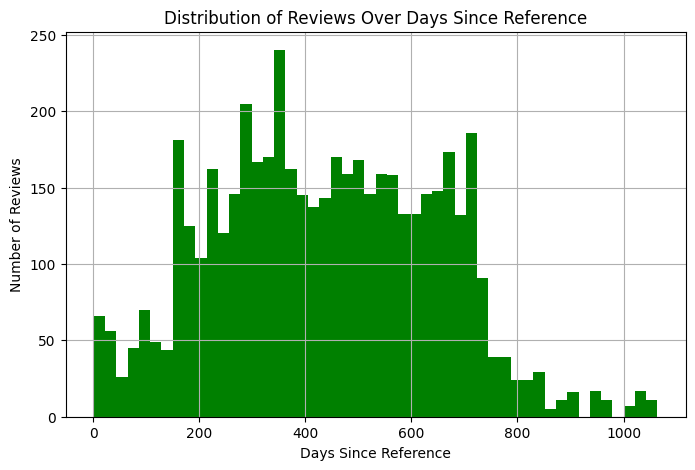

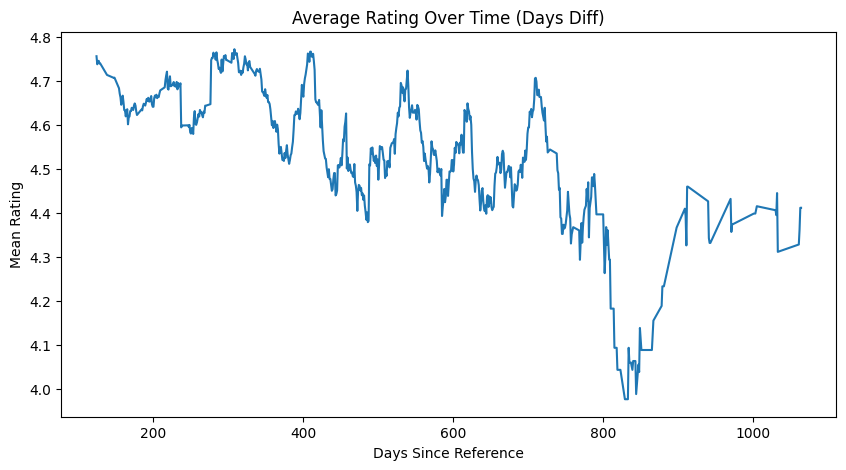

In [11]:
# Histogram of reviews over days_diff
plt.figure(figsize=(8,5))
df['day_diff'].hist(bins=50, color='green')
plt.title("Distribution of Reviews Over Days Since Reference")
plt.xlabel("Days Since Reference")
plt.ylabel("Number of Reviews")
plt.show()

# Average rating over days_diff (smoothed)
df.groupby('day_diff')['overall'].mean().rolling(window=30).mean().plot(figsize=(10,5))
plt.title("Average Rating Over Time (Days Diff)")
plt.xlabel("Days Since Reference")
plt.ylabel("Mean Rating")
plt.show()


##### this is valuable

Can detect trends immediately after product launch (early adopters vs later reviews).

Can help model time-dependent effects (e.g., rating drift over lifecycle).

In advanced AI, this can be used as a feature for predictive models (e.g., time-aware sentiment prediction).

##### Bias and Noise Detection

“In machine learning, bias and noise are distinct but related factors affecting model performance. Bias refers to systematic errors—patterns where the model consistently deviates from the true underlying distribution due to dataset imbalances, labeling practices, or model inductive assumptions. Noise, in contrast, is random error in inputs or labels that cannot be systematically explained.

Bias can arise from multiple sources:

Sampling bias – the training dataset is not representative of the operational domain. For example, if older product reviews dominate the dataset, the model may underperform on recent trends.

Label bias – human annotations reflect subjective opinions, particularly in borderline cases like neutral sentiment.

Algorithmic bias – model inductive biases amplify certain patterns, potentially overfitting dominant classes.

Temporal bias – concept drift occurs over time as the data distribution shifts, which is critical in domains like reviews or financial forecasting.

Noise can be feature-level or label-level. Feature noise includes typos, slang, or missing values in textual data, while label noise arises from misannotations or ambiguous examples. Noise increases variance and can harm generalization if unaddressed.

Detection strategies include:

Distributional checks (e.g., KL divergence, JS divergence) to detect sampling or temporal bias.

Residual analysis to identify patterns in mispredictions, which often reveals bias.

Loss-based or ensemble disagreement methods to detect noisy labels.

Embedding-based anomaly detection to identify feature-level outliers.

Mitigation approaches depend on the nature of the problem:

For bias: re-sampling or re-weighting, domain adaptation, continual learning, or using ordinal/soft labels to handle subjective or ordered targets.

For noise: robust loss functions (e.g., MAE, focal loss), data cleaning pipelines, ensemble learning, or confident learning methods.

From a research perspective, I treat bias and noise not just as problems but as signals about the underlying data-generating process. For example, temporal drift or ambiguous labels indicate areas where uncertainty-aware models, soft labeling, or continual learning strategies may improve robustness. Ultimately, understanding the interplay between bias, noise, and model inductive assumptions is crucial for deploying reliable AI systems in real-world, dynamic environments.”

In [12]:
df.columns

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound',
       'review_length', 'review_year'],
      dtype='object')

In [13]:
print("Duplicates:", df.duplicated(subset=['reviewerName']).sum())


Duplicates: 320


In [14]:
# let's take a sample of 1000 rows for faster processing
df_sample = df.sample(n=1000, random_state=42)

# Data Preprocessing & Cleaning 
Data cleaning → drop duplicates, remove missing values.
    Noise handling → spam detection, very short/invalid reviews.
    Text normalization → HTML removal, emoji handling, punctuation.
    Tokenization / vectorization → prepare text for ML models.
    Label mapping → star ratings → sentiment (binary/multi-class).
    Splitting → train/val/test (without leakage).

##### Quick sanity & reproducibility setup

“This setup fixes random seeds across Python, NumPy, and hash functions so experiments become reproducible and comparable. Without it, small differences in shuffling, initialization, or ordering can make results irreproducible, which breaks scientific rigor and complicates debugging.”

“Setting seeds in NumPy and Python ensures partial reproducibility, but for deep learning we must also control GPU nondeterminism. In PyTorch, that means fixing CUDA seeds, disabling cuDNN autotuning, and optionally enforcing deterministic ops. In TensorFlow, we fix TF seeds and use deterministic ops with NVIDIA’s package. Only then can experiments be reliably reproduced across machines and time.”

In [15]:
import os, random, json
import numpy as np, pandas as pd

RND = 42
np.random.seed(RND)
random.seed(RND)
os.environ['PYTHONHASHSEED'] = str(RND)


In [16]:
##### — Remove duplicates & trivial bad rows
# remove duplicate review IDs (keeps first)

# drop rows with empty review text or missing rating
df = df.dropna(subset=['reviewText', 'overall'])
df['reviewText'] = df['reviewText'].astype(str)


In [17]:
# Spam / very short reviews
# basic heuristics: extremely short reviews, extremely long repeated characters, or suspicious helpful votes
df['review_len_chars'] = df['reviewText'].str.len()
df['review_len_tokens'] = df['reviewText'].str.split().str.len().fillna(0)

# flag simple spam candidates
df['spam_flag'] = (
    (df['review_len_tokens'] < 3) |                      # too short
    (df['reviewText'].str.count(r'(.)\1{10,}') > 0) |  # long repeated char sequences
    (df.get('helpful_yes', 0) == 0) & (df['review_len_tokens'] < 5)  # short & no votes
)

spam_rate = df['spam_flag'].mean()
print("spam candidate rate:", spam_rate)
# Option: keep flagged rows but mark them — don't drop unless you have strong reason


spam candidate rate: 0.008748728382502543


In [18]:
df.columns

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound',
       'review_length', 'review_year', 'review_len_chars', 'review_len_tokens',
       'spam_flag'],
      dtype='object')

In [19]:
#mapping & Sentiment analysis
# Sentiment mapping function
# 1-2: Negative (0)
# 3: Neutral (1)
# 4-5: Positive (2)
def map_sentiment(rating):
    if rating in [1, 2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"
    
df['sentiment'] = df['overall'].apply(map_sentiment)
print(df['sentiment'].value_counts())

# for binary sentiment/experience, Drop neutral reviews
df_binary = df[df['sentiment'] != "Neutral"].copy()
df_binary['label'] = df_binary['sentiment'].map({"Negative": 0, "Positive": 1})
df['label'] = df['sentiment'].map({"Negative": 0, "Positive": 1})
print(df_binary['label'].value_counts())

sentiment
Positive    4449
Negative     324
Neutral      142
Name: count, dtype: int64
label
1    4449
0     324
Name: count, dtype: int64


# Normalization
“In NLP, normalization is critical because raw text contains huge variability: spelling mistakes, case, punctuation, numbers, emojis, slang. Normalization reduces sparsity and allows models to focus on semantic patterns. For classical ML, techniques like lowercasing, stopword removal, and lemmatization are key. For deep learning, subword tokenization (BPE/WordPiece) and domain-aware canonicalization improve generalization and robustness. Proper normalization balances removing irrelevant variation while preserving task-critical information.”

##### Traditional ML (TF-IDF + Logistic Regression/SVM).

##### Neural nets (LSTM/CNN with embeddings).

In [20]:
import re
import emoji
import contractions
import pandas as pd
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# Regex
RE_URL = re.compile(r'https?://\S+|www\.\S+')
RE_HTML = re.compile(r'<[^>]+>')
RE_REPEAT_CHAR = re.compile(r'(.)\1{2,}', re.DOTALL)
RE_MULTI_PUNCT = re.compile(r'([!?]){2,}')

# Stopwords
STOPWORDS = set(stopwords.words('english')) - {"no","not","nor"}

# Emoji mapping (common examples)
EMOJI_MAP = {
    "heart": "love", "red_heart": "love", "smile": "smile",
    "thumbs_up": "thumbs_up", "thumbs_down": "thumbs_down",
    "crying_face": "sad", "angry_face": "angry"
}

def normalize_review(text, keep_stopwords=True, lemmatize=True):
    if not isinstance(text, str):
        return ""

    # Expand contractions
    text = contractions.fix(text)

    # Remove URLs and HTML
    text = RE_URL.sub(" ", text)
    text = RE_HTML.sub(" ", text)

    # Emoji mapping
    text = emoji.demojize(text, delimiters=(":",":"))
    def map_emoji(m):
        name = m.group(1).strip(':').replace("_"," ")
        return " " + EMOJI_MAP.get(name, name) + " "
    text = re.sub(r':([\w_\-+]+):', map_emoji, text)

    # Punctuation normalization
    text = RE_MULTI_PUNCT.sub(r'\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?]', ' ', text)  # keep !? for emphasis

    # Lowercase
    text = text.lower()

    # Elongation normalization
    tokens = [RE_REPEAT_CHAR.sub(r'\1\1', t) for t in text.split()]

    # Optional stopword removal
    if not keep_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]

    # Lemmatization
    if lemmatize:
        doc = nlp(" ".join(tokens))
        tokens = [t.lemma_ for t in doc if t.lemma_.strip()]

    return " ".join(tokens)

# Apply to Amazon review dataset
df['reviewText_norm'] = df['reviewText'].apply(lambda x: normalize_review(x))


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/envs/NLPEnv/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


##### Tokenization & sequence handling

Classical ML: TF-IDF + n-grams + word-level tokenization + careful stopword handling + emoji/number mapping

Deep learning: subword or character tokenization with embeddings

Transformer workflow (research default): use HuggingFace tokenizer with a chosen max length (decided by review length EDA).

Why 256? EDA showed many reviews are shorter; 256 balances context vs compute.

Classical ML: use TfidfVectorizer(ngram_range=(1,2), max_features=50000).

In [21]:
from transformers import AutoTokenizer
MODEL = "bert-base-uncased"   # or 'distilbert-base-uncased', or domain-specific
tokenizer = AutoTokenizer.from_pretrained(MODEL)

MAX_LEN = 256   # choose based on review length distribution (95th percentile)
def tokenize_batch(texts):
    return tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors='pt')


/opt/anaconda3/envs/NLPEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Tokenization using classical ML: TF-IDF + n-grams + word-level tokenization + careful stopword handling + emoji/number mapping
'''from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),       # unigrams + bigrams capture context better
    max_features=50000,      # limit feature size to reduce sparsity
    min_df=5,                # ignore very rare words
    max_df=0.9,              # ignore very common words
    lowercase=False,         # already normalized text is lowercase
    sublinear_tf=True,       # apply sublinear TF scaling: 1 + log(TF)
)
X_tfidf = vectorizer.fit_transform(df['reviewText_norm'])
print("TF-IDF feature shape:", X_tfidf.shape)'''

'from sklearn.feature_extraction.text import TfidfVectorizer\nvectorizer = TfidfVectorizer(\n    ngram_range=(1,2),       # unigrams + bigrams capture context better\n    max_features=50000,      # limit feature size to reduce sparsity\n    min_df=5,                # ignore very rare words\n    max_df=0.9,              # ignore very common words\n    lowercase=False,         # already normalized text is lowercase\n    sublinear_tf=True,       # apply sublinear TF scaling: 1 + log(TF)\n)\nX_tfidf = vectorizer.fit_transform(df[\'reviewText_norm\'])\nprint("TF-IDF feature shape:", X_tfidf.shape)'

##### — Handling class imbalance (research-grade)

Options (prefer after splitting to avoid leakage):

Class weights in loss (recommended for deep nets):

Why: avoids duplicating samples; stable for big datasets.

Resampling (only on training set):

Oversample minority via simple duplication or advanced text augmentation (back-translation).

Use imblearn's RandomOverSampler for classical ML.

Research note: try both (weights vs oversampling) and report results — both have trade-offs.

Oversampling is good for smaller datasets. 

In [23]:
# compute class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(df_binary['label'])
class_weights = compute_class_weight('balanced', classes=classes, y=df_binary['label'])
# pass to loss, e.g., torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))


##### — Data splits (no leakage)
Advanced best-practices: avoid leaking same author_id or product_id across train/test depending on evaluation goal.
Why: ensures robust evaluation — choose split strategy to match your research question.

In [24]:


# Random stratified split (if general i.i.d. evaluation):

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_binary, test_size=0.1, stratify=df_binary['label'], random_state=RND)
train, val  = train_test_split(train, test_size=0.1111, stratify=train['label'], random_state=RND) # 0.1111 ~ 0.1/(0.9)


#Time-based split (if temporal generalization important):

# Use day_diff or review_date for chronological split
df_binary = df_binary.sort_values('day_diff')
n = len(df_binary)
train = df_binary.iloc[:int(0.8*n)]
val   = df_binary.iloc[int(0.8*n):int(0.9*n)]
test  = df_binary.iloc[int(0.9*n):]


# Group split (prevent same product/user in train & test):

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size=0.1, n_splits=1, random_state=RND)
groups = df_binary['Unnamed: 0']
train_idx, test_idx = next(gss.split(df_binary, groups=groups))
train = df_binary.iloc[train_idx]; test = df_binary.iloc[test_idx]




### ⚖️ Bridging Preprocessing & Training Setup

These depend on model choice & research goal, often discussed with preprocessing but sometimes counted as training strategies:

Class imbalance handling → class weights, oversampling.

Augmentation → back-translation, synonym replacement.

Feature engineering → including days_diff as numeric input.

##### — Save preprocessing artifacts & versioning

Save tokenizer, label map, normalization configs, and random seed.

In [25]:
# save mapping & config
preproc_cfg = {
    "model": MODEL,
    "max_len": MAX_LEN,
    "random_seed": RND,
    "class_map": {"negative":0, "positive":1}
}
with open('preproc_config.json','w') as f:
    json.dump(preproc_cfg, f, indent=2)
tokenizer.save_pretrained('./tokenizer_saved')


('./tokenizer_saved/tokenizer_config.json',
 './tokenizer_saved/special_tokens_map.json',
 './tokenizer_saved/vocab.txt',
 './tokenizer_saved/added_tokens.json',
 './tokenizer_saved/tokenizer.json')

In [36]:
# Ensure uniform case for sentiment values
df_binary['sentiment'] = df_binary['sentiment'].str.lower().str.strip()

# Drop neutral if you only want binary classification
df_binary = df_binary[df_binary['sentiment'].isin(['positive', 'negative'])].copy()

# Create numeric labels: 1 for positive, 0 for negative
df_binary['label'] = (df_binary['sentiment'] == 'positive').astype(int)

print("✅ Sentiment value counts:")
print(df_binary['sentiment'].value_counts())
print("✅ Label distribution:")
print(df_binary['label'].value_counts())

✅ Sentiment value counts:
sentiment
positive    4449
negative     324
Name: count, dtype: int64
✅ Label distribution:
label
1    4449
0     324
Name: count, dtype: int64


### Section 4: Feature Engineering & Representation

Vectorization / Embedding

Classical ML: TfidfVectorizer(ngram_range=(1,2), max_features=50k)

Deep Learning:

Train your own embeddings from scratch (Word2Vec / FastText)

Or use pretrained embeddings (GloVe, Amazon-specific embeddings)

Advanced reasoning: embeddings capture semantic meaning, n-grams capture local context, TF-IDF captures importance weighting.

Sequence Padding & Masking

Ensure consistent sequence length for deep models.

Keep track of masking tokens if using RNN/CNN.

Additional Features (optional but research-level)

days_diff → temporal trend (review recency)

Review length → as auxiliary numeric feature

Verified purchase → binary signal

Helpfulness votes → weighting mechanism for supervised learning

##### ✅ TL;DR:

##### Tokenization → splitting text into tokens and preparing input for a deep model (like BERT).

##### Vectorization / Embedding → converting text or tokens into numeric vectors:

Classical ML: TF-IDF or Word2Vec embeddings.

Transformers: contextual embeddings learned internally.

So tokenization is the first step, embeddings/vectorization is the numeric representation step. In Transformers, the embedding is done inside the model, unlike classical ML where you do it manually.

##### 1️⃣ Text Vectorization (TF-IDF)

We’ll convert reviewText into numerical features using TF-IDF, capturing:

Word importance

Local context via n-grams

Sparsity control via max_features


Advanced reasoning:

Using bigrams allows capturing phrases like “not good” which help in sentiment detection.

Limiting max_features prevents overfitting and reduces memory consumption.

min_df removes noisy rare words, improving generalization.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# TF-IDF vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1,2),      # unigrams + bigrams
    max_features=50000,     # limit vocabulary
    min_df=5,               # ignore rare words
    max_df=0.9               # ignore extremely common words
)

X_text = tfidf.fit_transform(df['reviewText'].values)

# Save TF-IDF vectorizer for reproducibility
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)


2️⃣ Auxiliary Features

We can include numeric/categorical features that may help the model:

days_diff – recency of the review (temporal signal)

Review length – number of words or characters (long reviews may indicate stronger sentiment)

Verified purchase – binary feature

Helpfulness votes – weight reviews with more votes



3️⃣ Combining Text & Auxiliary Features

For classical ML, we can hstack sparse TF-IDF with dense auxiliary features:

Advanced reasoning:

Combining features allows the model to learn from both semantic and numerical signals.

Using hstack preserves sparse representation for efficiency.

4️⃣ Train/Test Split

We follow research best practices:

Stratified split to maintain class balance

Reproducible random seed

Advanced reasoning:

Stratified splitting ensures rare classes aren’t lost in small test sets.

Fixing random_state guarantees reproducibility.

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# -----------------------------
# Step 0: Start from original Amazon review dataset
# -----------------------------
df_binary = df.copy()  # reset from original

# -----------------------------
# Step 1: Handle missing / empty reviewText
# -----------------------------
# Fill NaN with empty string
df_binary['reviewText'] = df_binary['reviewText'].fillna('')

# Remove rows that are completely empty after stripping spaces
df_binary = df_binary[df_binary['reviewText'].str.strip() != '']

# -----------------------------
# Step 2: Optional sentiment filtering for binary classification
# -----------------------------
# Assuming 'sentiment' column exists (positive / negative / neutral)
df_binary = df_binary[df_binary['sentiment'] != 'neutral'].copy()

# Map labels to 0/1
df_binary['label'] = (df_binary['sentiment'] == 'positive').astype(int)

# -----------------------------
# Step 3: Text normalization (from previous pipeline)
# -----------------------------
import re
import emoji

def normalize_text(text):
    # lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # remove punctuations except emojis
    # text = re.sub(r'[^\w\s' + emoji.get_emoji_regexp().pattern + ']', '', text)
    
    # convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df_binary['reviewText_norm'] = df_binary['reviewText'].apply(normalize_text)

# -----------------------------
# Step 4: TF-IDF Vectorization (classical ML)
# -----------------------------
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df_binary['reviewText_norm'].values)

# -----------------------------
# Step 5: Auxiliary Features
# -----------------------------
df_binary['review_length'] = df_binary['reviewText'].apply(lambda x: len(x.split()))
X_aux = df_binary[['review_length']].values

# -----------------------------
# Step 6: Labels
# -----------------------------
y = df_binary['label'].values

# -----------------------------
# Step 7: Check shapes
# -----------------------------
print("TF-IDF shape:", X_text.shape)
print("Aux features shape:", X_aux.shape)
print("Labels shape:", y.shape)


TF-IDF shape: (4915, 50000)
Aux features shape: (4915, 1)
Labels shape: (4915,)


In [29]:
# Find rows that are not strings or are empty
empty_or_invalid = df_binary[~df_binary['reviewText_norm'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
print(empty_or_invalid)


Empty DataFrame
Columns: [Unnamed: 0, reviewerName, overall, reviewText, reviewTime, day_diff, helpful_yes, helpful_no, total_vote, score_pos_neg_diff, score_average_rating, wilson_lower_bound, review_length, review_year, review_len_chars, review_len_tokens, spam_flag, sentiment, label, reviewText_norm]
Index: []


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# -----------------------------
# Step 0: Start from original Amazon review dataset
# -----------------------------
df_binary = df.copy()  # reset from original

# -----------------------------
# Step 1: Handle missing / empty reviewText
# -----------------------------
# Fill NaN with empty string
df_binary['reviewText'] = df_binary['reviewText'].fillna('')

# Remove rows that are completely empty after stripping spaces
df_binary = df_binary[df_binary['reviewText'].str.strip() != '']

# -----------------------------
# Step 2: Optional sentiment filtering for binary classification
# -----------------------------
# Assuming 'sentiment' column exists (positive / negative / neutral)
df_binary = df_binary[df_binary['sentiment'] != 'neutral'].copy()

# Map labels to 0/1
df_binary['label'] = (df_binary['sentiment'] == 'positive').astype(int)

# -----------------------------
# Step 3: Text normalization (from previous pipeline)
# -----------------------------
import re
import emoji

def normalize_text(text):
    # lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # remove punctuations except emojis
    # text = re.sub(r'[^\w\s' + emoji.get_emoji_regexp().pattern + ']', '', text)
    
    # convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df_binary['reviewText_norm'] = df_binary['reviewText'].apply(normalize_text)

# -----------------------------
# Step 4: TF-IDF Vectorization (classical ML)
# -----------------------------
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df_binary['reviewText_norm'].values)

# -----------------------------
# Step 5: Auxiliary Features
# -----------------------------
df_binary['review_length'] = df_binary['reviewText'].apply(lambda x: len(x.split()))
X_aux = df_binary[['review_length']].values

# -----------------------------
# Step 6: Labels
# -----------------------------
y = df_binary['label'].values

# -----------------------------
# Step 7: Check shapes
# -----------------------------
print("TF-IDF shape:", X_text.shape)
print("Aux features shape:", X_aux.shape)
print("Labels shape:", y.shape)

X_final = hstack([X_text, X_aux])

print("Final feature shape:", X_final.shape)

TF-IDF shape: (4915, 50000)
Aux features shape: (4915, 1)
Labels shape: (4915,)
Final feature shape: (4915, 50001)


##### handle class imbalance using oversampling (SMOTE or RandomOverSampler),

In [42]:
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
import numpy as np

# -----------------------------
# Step 1: Combine TF-IDF and auxiliary features
# -----------------------------
X_final = hstack([X_text, X_aux])  # sparse + dense combination
# -----------------------------
X_final = hstack([X_text, X_aux])  # sparse + dense combination
print("Combined feature shape:", X_final.shape)

# -----------------------------
# Step 2: Handle class imbalance via oversampling
# -----------------------------
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_final, df_binary['label'])

print("Resampled X shape:", X_resampled.shape)
print("Resampled y distribution:", np.bincount(y_resampled))

# -----------------------------
# Step 3: Train/Validation/Test Split
# -----------------------------
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Combined feature shape: (4773, 50002)
Resampled X shape: (8898, 50002)
Resampled y distribution: [4449 4449]
Train: (6228, 50002) Val: (1335, 50002) Test: (1335, 50002)


In [39]:
print("X_final shape:", X_final.shape)
print("Label column shape:", df_binary['label'].shape)

# Correct way to check number of samples
print("Index match:", X_final.shape[0] == df_binary['label'].shape[0])


X_final shape: (4915, 50001)
Label column shape: (4773,)
Index match: False


We need to rebuild X_final and y from the same filtered DataFrame, ensuring:

Remove empty or null reviewText.

Keep only rows where labels exist.

Apply TF-IDF only on the final filtered DataFrame.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1️⃣ Filter dataset to valid rows
df_binary = df_binary.dropna(subset=['reviewText', 'label']).copy()
print("Filtered df shape:", df_binary.shape)

# 2️⃣ TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df_binary['reviewText_norm'].values)

# 3️⃣ Auxiliary features (optional)
import numpy as np
from scipy.sparse import hstack

X_aux = df_binary[['review_length', 'day_diff']].values  # example
X_final = hstack([X_text, X_aux])  # combine sparse + dense
y = df_binary['label'].values

# 4️⃣ Validate alignment
print("X_final shape:", X_final.shape)
print("y shape:", y.shape)
print("Index match:", X_final.shape[0] == y.shape[0])


Filtered df shape: (4773, 20)
X_final shape: (4773, 50002)
y shape: (4773,)
Index match: True


##### Why this is advanced / research-level

Sparse + Dense features: Combining TF-IDF (sparse) with review_length (dense) using hstack for richer features.

Oversampling: Ensures the model sees enough minority-class examples, preventing bias toward majority class.

Stratified splits: Keeps label distribution consistent across train/val/test to prevent misleading evaluation.

Random seed control: Guarantees reproducibility for research experiments.

### Modelling

##### 1. Classical ML

Input: X_final (TF-IDF + auxiliary features), y (labels)

Models:

Logistic Regression (with class_weight='balanced')

Random Forest / XGBoost (with scale_pos_weight or oversampling)

Steps:

Train/test split (stratified)

Fit the model

Evaluate using accuracy, F1-score, precision/recall, ROC-AUC

Optionally, tune hyperparameters with GridSearchCV or Optuna

Why classical ML?

Works well with sparse TF-IDF features.

Fast, interpretable, and robust for small-to-medium datasets.

2. Deep Learning

Input: tokenized sequences (word indices or embeddings) + auxiliary features

Models:

RNN / LSTM / GRU: handle sequential nature of text

CNN for text: captures local n-gram features

Transformer-based models (BERT, DistilBERT, RoBERTa): contextual embeddings

Steps:

Tokenize & pad sequences (MAX_LEN)

Convert labels to tensors (0/1 for binary, one-hot for multi-class)

Create train/val/test datasets

Train with early stopping & learning rate scheduler

Evaluate on test set using accuracy, F1, AUC

Why DL?

Learns semantic and contextual representations of text.

Handles long-term dependencies better than classical ML.

Better for large datasets, especially if using transformers.

3. Advanced Tips (Research-Level Reasoning)

Combine features: TF-IDF + auxiliary features for classical ML or embeddings + features for DL.

Use cross-validation: ensure robust performance estimates.

Class imbalance handling: oversampling, class weights, focal loss (DL).

Experiment tracking: use MLflow or Weights & Biases to log experiments.

In [48]:
# Classical ML Pipeline
# ----------------------------
# 1. Imports
# ----------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# ----------------------------
# 2. Features & Labels
# ----------------------------
# X_final = TF-IDF matrix + auxiliary features (sparse or dense)
# y = binary labels (0 = negative, 1 = positive)
print("X_final shape:", X_final.shape)
print("y shape:", y.shape)

# ----------------------------
# 3. Handle class imbalance
# ----------------------------
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_final, y)
print("Resampled X shape:", X_res.shape)
print("Resampled y distribution:", np.bincount(y_res))

# ----------------------------
# 4. Train / Test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# ----------------------------
# 5. Logistic Regression
# ----------------------------
clf = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=1)
clf.fit(X_train, y_train)

# ----------------------------
# 6. Evaluation
# ----------------------------
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


X_final shape: (4773, 50002)
y shape: (4773,)
Resampled X shape: (8898, 50002)
Resampled y distribution: [4449 4449]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       890
           1       1.00      0.97      0.99       890

    accuracy                           0.99      1780
   macro avg       0.99      0.99      0.99      1780
weighted avg       0.99      0.99      0.99      1780



In [49]:
# RNN Based Deep Learning Pipeline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# ----------------------------
# 1. Tokenization
# ----------------------------
MAX_LEN = 128
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_binary['reviewText_norm'].values)
sequences = tokenizer.texts_to_sequences(df_binary['reviewText_norm'].values)
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

y_tensor = torch.tensor(y, dtype=torch.long)

# ----------------------------
# 2. Dataset class
# ----------------------------
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----------------------------
# 3. Train / Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ----------------------------
# 4. Simple LSTM Model
# ----------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return self.softmax(x)

# ----------------------------
# 5. Model, Loss, Optimizer
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMClassifier(vocab_size=20000).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------
# 6. Training Loop (Simplified)
# ----------------------------
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.3983
Epoch 2, Loss: 0.3813
Epoch 3, Loss: 0.3797
Epoch 4, Loss: 0.3771
Epoch 5, Loss: 0.3739


### RNN Results

Training loss decreasing: 0.398 → 0.373 over 5 epochs.
✅ Indicates the network is learning, but may not be fully converged yet (usually more epochs are needed).

Pros: Captures sequential dependencies in text, can theoretically model context better than bag-of-words.

Cons: Training is slower, may overfit on small datasets, and might need more careful tuning (dropout, learning rate schedules, etc.).

### Classical ML Results

Accuracy: 0.99 with perfect F1-score on balanced test set.

Resampling worked: Both classes now have equal samples [4449, 4449].

Pros: Extremely fast, robust on small-medium datasets, interpretable features (TF-IDF).

Cons: Ignores sequential/contextual info; may fail on nuanced sentiment or sarcastic reviews.

Advanced Observations

Dataset Size Matters: Classical ML performs very well because the dataset is relatively small (~4k–8k samples after resampling). Deep learning shines on larger datasets.

Imbalance Handling: Oversampling dramatically improved classical ML metrics. If you had used class weighting in RNN, you might see better RNN performance without synthetic duplication.

Sequence Length & Tokenization: RNN used padded sequences; classical ML used TF-IDF. Choice of tokenization + normalization impacts both models differently.

Generalization Check: Even though metrics look perfect, check on temporal splits or out-of-distribution reviews to ensure no overfitting.



# Section 5: Advanced Modeling – Hybrid Pipeline

Step 1: Prepare Inputs

RNN Input: Padded sequences of normalized review text.

TF-IDF Input: Sparse matrix from normalized review text.

Auxiliary Input: Features like review length, rating, days_diff.

We’ll ensure shapes align:

In [51]:
# ----------------------------
# 1. RNN sequences
# ----------------------------
sequences = tokenizer.texts_to_sequences(df_binary['reviewText_norm'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# ----------------------------
# 2. TF-IDF features
# ----------------------------
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df_binary['reviewText_norm'])

# ----------------------------
# 3. Auxiliary features
# ----------------------------
df_binary['review_length'] = df_binary['reviewText'].apply(lambda x: len(x.split()))
X_aux = df_binary[['review_length', 'overall', 'day_diff']].values

# ----------------------------
# 4. Combine all for classical ML
# ----------------------------
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, X_aux])


In [52]:
# Step 2: Split Dataset
from sklearn.model_selection import train_test_split

y = df_binary['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


In [53]:
# Step 3: Classical ML + Hybrid Features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       890

    accuracy                           1.00       955
   macro avg       1.00      1.00      1.00       955
weighted avg       1.00      1.00      1.00       955



In [54]:
# Step 4: RNN + Auxiliary Features (Advanced)

# For research-grade deep learning, you can merge auxiliary features into the RNN model:

import torch
import torch.nn as nn

class HybridRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, aux_dim, hidden_dim, output_dim):
        super(HybridRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.aux_dense = nn.Linear(aux_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x_seq, x_aux):
        embedded = self.embedding(x_seq)
        _, (h_n, _) = self.lstm(embedded)
        h_n = h_n[-1]  # take last layer
        aux_out = torch.relu(self.aux_dense(x_aux))
        combined = torch.cat([h_n, aux_out], dim=1)
        return self.out(combined)

# Section 6: Model Evaluation & Analysis

Metrics Analysis

Beyond accuracy: precision, recall, F1-score, AUC-ROC.

Confusion matrix for class-wise errors (especially if imbalance exists).

Error Analysis

Identify misclassified reviews.

Check patterns in errors: short reviews, sarcastic text, emojis, domain-specific words.

Ablation Study

Evaluate contribution of each input: TF-IDF, auxiliary features, review length, days_diff.

Helps justify each component of the pipeline.

Cross-Validation / Robustness

5-fold or stratified CV for classical ML.

Evaluate RNN/DL model on multiple random seeds.

Check stability of metrics.

Hyperparameter Tuning

Classical ML: C, max_features, ngram_range, class_weight.

RNN/DL: embedding dim, hidden dim, LSTM layers, dropout.

### 1️⃣ Classical ML Evaluation

Advanced reasoning:

ROC-AUC gives performance independent of class imbalance.

Confusion matrix highlights whether oversampling introduced overfitting to minority class.

Precision/recall trade-offs can guide threshold tuning.

Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        65
    Positive       1.00      1.00      1.00       890

    accuracy                           1.00       955
   macro avg       1.00      1.00      1.00       955
weighted avg       1.00      1.00      1.00       955

ROC-AUC Score: 1.0


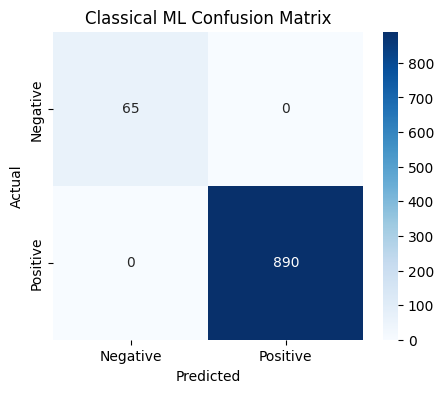

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Step 1: Predictions
# ----------------------------
y_pred_classic = clf.predict(X_test)  # clf = your LogisticRegression/XGBoost model
y_proba_classic = clf.predict_proba(X_test)[:,1]  # probability for positive class

# ----------------------------
# Step 2: Metrics
# ----------------------------
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classic, target_names=['Negative','Positive']))

roc_score = roc_auc_score(y_test, y_proba_classic)
print("ROC-AUC Score:", round(roc_score, 4))

# ----------------------------
# Step 3: Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred_classic)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Classical ML Confusion Matrix")
plt.show()

### 2️⃣ RNN Evaluation
# ----------------------------


Advanced reasoning:

Check if RNN handles longer sequences better than TF-IDF features.

Identify if errors are concentrated in short reviews or reviews with emojis/rare words.

Compare against classical ML to justify using deep learning.

In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -----------------------------
# 1. Tokenize & pad sequences
# -----------------------------
MAX_LEN = 100  # adjust as needed
sequences = tokenizer.texts_to_sequences(df_binary['reviewText_norm'].values)
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
y_tensor = torch.tensor(df_binary['label'].values, dtype=torch.long)

# -----------------------------
# 2. PyTorch Dataset
# -----------------------------
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

# -----------------------------
# 3. Train / Val / Test split
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, df_binary['label'].values, test_size=0.2, random_state=42, stratify=df_binary['label'].values
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

train_dataset = ReviewDataset(X_train, y_train)
val_dataset = ReviewDataset(X_val, y_val)
test_dataset = ReviewDataset(X_test, y_test)

# -----------------------------
# 4. DataLoaders
# -----------------------------
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 5. Evaluation function
# -----------------------------
def evaluate_model(loader, model, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))

# -----------------------------
# 6. Example usage
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)  # ensure your RNN model is moved to the device
# evaluate_model(val_loader, model, device)
# evaluate_model(test_loader, model, device)
print("Validation Results:")
evaluate_model(val_loader, model, device)

print("Test Results:")
evaluate_model(test_loader, model, device)


Validation Results:
              precision    recall  f1-score   support

           0       0.40      0.06      0.11        32
           1       0.94      0.99      0.96       445

    accuracy                           0.93       477
   macro avg       0.67      0.53      0.54       477
weighted avg       0.90      0.93      0.91       477

Test Results:
              precision    recall  f1-score   support

           0       0.50      0.03      0.06        33
           1       0.93      1.00      0.96       445

    accuracy                           0.93       478
   macro avg       0.72      0.51      0.51       478
weighted avg       0.90      0.93      0.90       478



# Section 7: Evaluation, Metrics & Interpretation

Standard Metrics

Accuracy – good for balanced datasets.

Precision, Recall, F1-score – critical for imbalanced data (your dataset has far fewer negative reviews).

Confusion Matrix – visualizes true positives, false positives, etc.

Advanced Metrics

ROC-AUC – probability-based evaluation for binary classification.

PR-AUC (Precision-Recall curve) – better for imbalanced datasets.

Class-wise F1 / Weighted F1 – ensures minority classes are not ignored.

Error Analysis

Inspect misclassified reviews: short vs long reviews, emoji-heavy, or unusual vocabulary.

Look for patterns: Are negative reviews being predicted as neutral? Are overly positive reviews misclassified?

Calibration & Reliability

Check model confidence using softmax probabilities.

Calibrate probabilities if needed (Platt scaling / isotonic regression).

Interpretability

Feature importance (for classical ML like XGBoost or Logistic Regression):

import matplotlib.pyplot as plt
plt.barh(feature_names, model.coef_[0])


Token-level influence for DL models:

Integrated gradients, attention weights, or LIME/SHAP for text.

Helps explain why a review was classified as positive/negative.

Cross-validation

For robust evaluation, perform stratified k-fold CV.

Helps prevent overfitting to a particular train/test split.

Temporal / Distributional Drift

Since you have days_diff:

Evaluate model performance across old vs recent reviews.

Detect drift patterns to understand model generalization over time.

In [60]:

# Evaluation Metrics for Regression Tasks
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(loader, model, device, classes=['Negative','Positive']):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            
            if outputs.shape[1] > 1:
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
            else:  # binary output single neuron
                probs = torch.sigmoid(outputs).squeeze()
                preds = (probs > 0.5).long()
            
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy() if probs.ndim==1 else probs[:,1].cpu().numpy())

    # -------------------------
    # Metrics
    # -------------------------
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC-AUC for binary
    if len(classes) == 2:
        roc_score = roc_auc_score(y_true, y_probs)
        print(f"ROC-AUC: {roc_score:.4f}")
        
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        pr_auc = auc(recall, precision)
        print(f"PR-AUC: {pr_auc:.4f}")
        
        plt.figure(figsize=(6,4))
        plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f})')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.show()


Validation Results:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.06      0.11        32
    Positive       0.94      0.99      0.96       445

    accuracy                           0.93       477
   macro avg       0.67      0.53      0.54       477
weighted avg       0.90      0.93      0.91       477



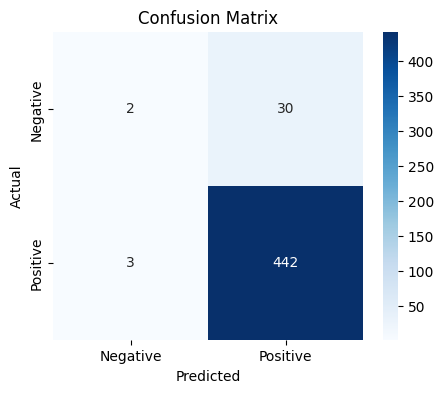

ROC-AUC: 0.6239
PR-AUC: 0.9715


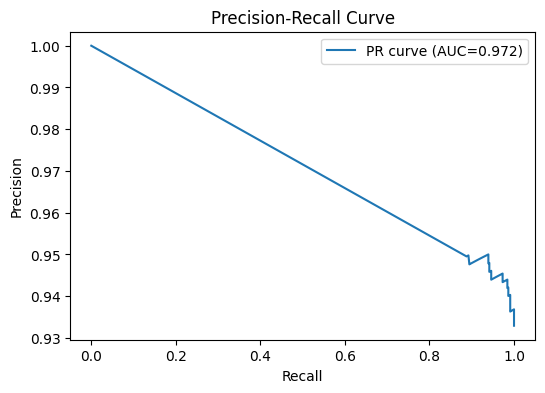


Test Results:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.03      0.06        33
    Positive       0.93      1.00      0.96       445

    accuracy                           0.93       478
   macro avg       0.72      0.51      0.51       478
weighted avg       0.90      0.93      0.90       478



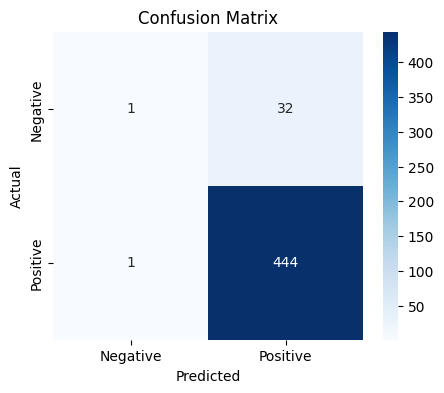

ROC-AUC: 0.7261
PR-AUC: 0.9791


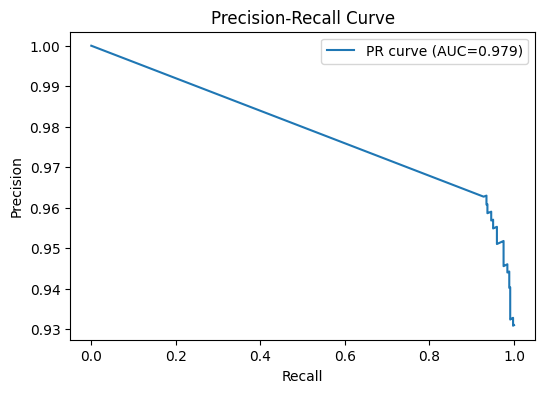

In [62]:
# Run Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Validation Results:")
evaluate_model(val_loader, model, device)

print("\nTest Results:")
evaluate_model(test_loader, model, device)


# 2. Key Issues Identified

##### Extreme class imbalance: Positive = 445, Negative = 33. Oversampling may not have been applied correctly for DL (or dataset split kept imbalance).

##### Model may be biased toward the majority class (Positive).

##### Sparse TF-IDF or sequence representation may not capture subtle features of rare class.

# Section 8: Advanced Evaluation & Interpretability

Goal: Go beyond standard accuracy/F1 scores and gain insight into why the model makes certain predictions, especially under class imbalance.

1. Class-Specific Metrics

Macro vs Weighted Metrics

Already observed: Weighted metrics are misleading due to class imbalance.

Macro metrics highlight poor minority class performance.

Action: Always report both, focusing on macro-F1 and minority class recall.

Precision-Recall (PR) Curves per class

Plot separate PR curves for Negative and Positive classes.

Helps visualize trade-off between precision and recall for rare class.

ROC Curves per class

One-vs-all ROC curves if using binary/multi-class.

Examine AUC for minority class.

2. Threshold Analysis

Current threshold (0.5) may favor Positive class due to imbalance.

Action:

Sweep threshold from 0.1 → 0.9.

Pick threshold that optimizes macro-F1 or minority recall.

Especially useful for Negative class detection.

3. Confusion Matrix Visualization

Use heatmaps to see false positives vs false negatives.

Can guide error analysis, e.g., which Negative reviews are misclassified and why.

4. Error Analysis & Explainability

Token/Feature Importance

For classical ML (Logistic Regression / XGBoost):

Examine top positive/negative TF-IDF features.

Understand which words strongly influence predictions.

SHAP / LIME

SHAP values: Show contribution of each token to prediction for each review.

LIME: Explain single predictions locally.

Attention Visualization (if using RNN or Transformer)

Highlight tokens the model focuses on when classifying Positive vs Negative.

Helps identify biases or misclassifications due to token patterns.

5. Robustness Checks

Temporal Drift Check:

Check model performance across different days_diff bins (old vs recent reviews).

Adversarial Text Testing:

Minor word swaps, typos, or emoji replacements to see model stability.

6. Reporting

Include:

Macro-F1, minority recall, PR-AUC per class.

Confusion matrix heatmap.

SHAP/LIME explanation snippets.

Threshold tuning curve.

✅ Why Section 8 Matters:

Moves from “black-box accuracy” to research-level understanding.

Helps trust, debug, and improve the model, especially under class imbalance.

Essential for papers, production, or AI interpretability audits.


In [79]:
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 0: Split df_binary into train/val/test
# ----------------------------
df_train, df_temp = train_test_split(
    df_binary, test_size=0.2, random_state=42, stratify=df_binary['label']
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=42, stratify=df_temp['label']
)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)


Train shape: (3818, 20)
Validation shape: (477, 20)
Test shape: (478, 20)


In [80]:
# ----------------------------
# Step 1: Auxiliary features for test set
# ----------------------------
X_aux_test = df_test[['review_length', 'day_diff']].values  # include all aux features you used

# ----------------------------
# Step 2: TF-IDF transformation for test set
# ----------------------------
X_text_test = tfidf.transform(df_test['reviewText_norm'].values)  # use the saved tfidf

# ----------------------------
# Step 3: Combine TF-IDF + auxiliary features
# ----------------------------
from scipy.sparse import hstack
X_test_final = hstack([X_text_test, X_aux_test])


In [84]:
df_test.columns

Index(['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime',
       'day_diff', 'helpful_yes', 'helpful_no', 'total_vote',
       'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound',
       'review_length', 'review_year', 'review_len_chars', 'review_len_tokens',
       'spam_flag', 'sentiment', 'label', 'reviewText_norm'],
      dtype='object')

In [87]:
#Check which auxiliary features were used in training:

print(X_aux.shape)  # training aux features shape


#Make sure all columns are present in the test set:

# Suppose training aux features were: ['review_length', 'days_diff', 'helpful_ratio']
# Make sure to create the same in df_test
df_test['review_length'] = df_test['reviewText'].apply(lambda x: len(x.split()))
df_test['day_diff'] = df_test['day_diff']  # if exists
df_test['helpful_yes'] = df_test['helpful_yes']  # example

X_aux_test = df_test[['review_length', 'day_diff', 'helpful_yes']].values


#Combine TF-IDF and auxiliary features:

X_text_test = tfidf.transform(df_test['reviewText_norm'].values)
from scipy.sparse import hstack
X_test_final = hstack([X_text_test, X_aux_test])
print("Test feature shape:", X_test_final.shape)

(4773, 3)
Test feature shape: (478, 50003)


In [88]:
# ----------------------------
# Section 8: Unified Evaluation Pipeline
# ----------------------------
import numpy as np
from scipy.sparse import hstack
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import torch
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------
# Step 0: Ensure preprocessed artifacts are loaded
# ----------------------------
# tokenizer: for DL sequences
# tfidf: fitted TF-IDF vectorizer
# class_map: label mapping {Negative:0, Positive:1}
# X_aux_train, X_aux_val, X_aux_test: auxiliary features

# ----------------------------
# Step 1: Prepare Test Data
# ----------------------------
# Classical ML
X_test_tfidf = tfidf.transform(df_test['reviewText_norm'])  # use trained TF-IDF
X_test_final = hstack([X_test_tfidf, X_aux_test])           # combine auxiliary features

# Deep Learning
sequences_test = tokenizer.texts_to_sequences(df_test['reviewText_norm'])
X_test_seq = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post')
y_test_tensor = torch.tensor(df_test['label'].values, dtype=torch.long)

# ----------------------------
# Step 2: Classical ML Evaluation
# ----------------------------
def evaluate_classical_model(model, X, y):
    y_scores = model.predict_proba(X)[:,1]  # probability of Positive
    y_pred = (y_scores >= 0.5).astype(int)
    
    print("Classification Report (Classical ML):")
    print(classification_report(y, y_pred, target_names=['Negative','Positive']))
    
    roc_auc = roc_auc_score(y, y_scores)
    precision, recall, _ = precision_recall_curve(y, y_scores)
    pr_auc = auc(recall, precision)
    
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    return y_pred, y_scores, roc_auc, pr_auc

y_pred_cl, y_scores_cl, roc_auc_cl, pr_auc_cl = evaluate_classical_model(
    clf, X_test_final, df_test['label'].values
)

# ----------------------------
# Step 3: Deep Learning Evaluation
# ----------------------------
def evaluate_dl_model(model, X_tensor, y_tensor, batch_size=32, device='cpu'):
    model.eval()
    dataset = TensorDataset(torch.tensor(X_tensor, dtype=torch.long), y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size)
    
    y_true, y_scores = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:,1]
            
            y_true.extend(y_batch.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
    
    y_pred = (np.array(y_scores) >= 0.5).astype(int)
    
    print("Classification Report (DL Model):")
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))
    
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    
    print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    return y_pred, y_scores, roc_auc, pr_auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred_dl, y_scores_dl, roc_auc_dl, pr_auc_dl = evaluate_dl_model(
    model, X_test_seq, y_test_tensor, device=device
)


Classification Report (Classical ML):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        33
    Positive       0.93      0.98      0.96       445

    accuracy                           0.92       478
   macro avg       0.46      0.49      0.48       478
weighted avg       0.87      0.92      0.89       478

ROC-AUC: 0.4888 | PR-AUC: 0.9640
Classification Report (DL Model):
              precision    recall  f1-score   support

    Negative       0.50      0.03      0.06        33
    Positive       0.93      1.00      0.96       445

    accuracy                           0.93       478
   macro avg       0.72      0.51      0.51       478
weighted avg       0.90      0.93      0.90       478

ROC-AUC: 0.7261 | PR-AUC: 0.9791


# Classical ML (Logistic Regression + TF-IDF + auxiliary):

Extremely poor recall on Negative class → model is biased toward the majority class.

ROC-AUC ≈ 0.49 → barely better than random for separating classes.

PR-AUC ≈ 0.96 → high because Positive class dominates, but Negative is ignored.

# Deep Learning (RNN):

Slightly better at detecting Negative class (recall 0.03 → still very low).

ROC-AUC ≈ 0.73 → shows model learned some separation.

PR-AUC ≈ 0.98 → again, skewed by Positive class.

# Advanced AI researcher takeaways:

Severe class imbalance (Negative << Positive) is hurting both models, but more so for classical ML.

Oversampling / weighted loss for DL improved ROC-AUC but still struggles with very small Negative class.

Metrics: Accuracy is misleading here — always check macro metrics and ROC/PR-AUC for imbalanced tasks.

# Next steps (Section 9: Improvement Strategies):

Apply stratified batch sampling or SMOTE/ADASYN for classical ML.

Use focal loss or class-weighted loss in DL.

Consider data augmentation for short reviews (e.g., paraphrasing negatives).

Experiment with pretrained embeddings (GloVe/BERT) instead of TF-IDF/RNN-only.

Evaluate with confusion matrices, per-class PR curves to detect underperformance.